In [1]:
from mpl_toolkits.mplot3d import Axes3D
import copy as copylib
from progressbar import *
%pylab
%matplotlib inline
import pandas as pd
import numpy as np

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['Widget', 'array']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
oldDataFrame= pd.read_csv('tts.csv')
#use historical interst rate data from GOT
ON = oldDataFrame["ON"]
threeMonth = oldDataFrame["3M"]
sixMonth = oldDataFrame["6M"]
oneYear = oldDataFrame["1Y"]
twoYear = oldDataFrame["2Y"]
threeYear = oldDataFrame["3Y"]
fourYear = oldDataFrame["4Y"]
fiveYear = oldDataFrame["5Y"]

### HJM

In [3]:
df = pd.read_excel('historical rates.xlsx')
#dataframe = dataframe / 100 # Convert interest rates to %
#pandas.options.display.max_rows = 10

In [4]:
#df.head()

In [5]:
hist_timeline = list(df.index)
tenors = [float(x) for x in df.columns]
hist_rates = matrix(df)
#plot(hist_rates), xlabel(r'Time $t$'), title(r'Historical $f(t,\tau)$ by $t$'), show()
#plot(tenors, hist_rates.transpose()), xlabel(r'Tenor $\tau$'), title(r'Historical $f(t,\tau)$ by $\tau$');

In [6]:
diff_rates = diff(hist_rates, axis=0)
assert(hist_rates.shape[1]==diff_rates.shape[1])
#plot(diff_rates), xlabel(r'Time $t$'), title(r'$df(t,\tau)$ by $t$')

In [7]:
# Calculate covariance matrix
sigma = cov(diff_rates.transpose())
#print("Sigma shape : " + str(sigma.shape))

In [8]:
eigval, eigvec = linalg.eig(sigma)
eigvec=matrix(eigvec)
assert type(eigval) == ndarray
assert type(eigvec) == matrix
#print(eigval)

In [9]:
factors=3
index_eigvec = list(reversed(eigval.argsort()))[0:factors]   # highest principal component first in the array
princ_eigval = array([eigval[i] for i in index_eigvec])
princ_comp = hstack([eigvec[:,i] for i in index_eigvec])
#print("Principal eigenvalues")
#print(princ_eigval)
#print("Principal eigenvectors")
#print(princ_comp)
#plot(princ_comp, marker='.'), title('Principal components'), xlabel(r'Time $t$');

In [10]:
sqrt_eigval = matrix(princ_eigval ** .5)
tmp_m = vstack([sqrt_eigval for i in range(princ_comp.shape[0])])  # resize matrix (1,factors) to (n, factors)
vols = multiply(tmp_m, princ_comp) # multiply matrice element-wise
#print('vols shape: ' + str(vols.shape))
#plot(vols, marker='.'), xlabel(r'Time $t$'), ylabel(r'Volatility $\sigma$'), title('Discretized volatilities');

In [11]:
def get_matrix_column(mat, i):
    return array(mat[:,i].flatten())[0]

class PolynomialInterpolator:
    def __init__(self, params):
        assert type(params) == ndarray
        self.params = params
    def calc(self, x):
        n = len(self.params)
        C = self.params
        X = array([x**i for i in reversed(range(n))])
        return sum(multiply(X, C))

In [12]:
fitted_vols = []

/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


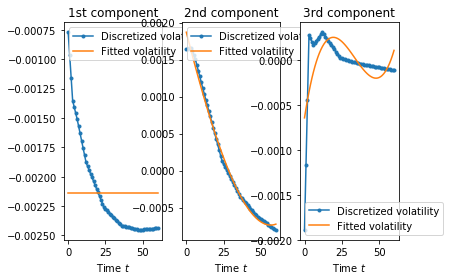

In [13]:
def fit_volatility(i, degree, title):
    vol = get_matrix_column(vols, i)
    fitted_vol = PolynomialInterpolator(polyfit(tenors, vol, degree))    
    plot(tenors, vol, marker='.', label='Discretized volatility')
    plot(tenors, [fitted_vol.calc(x) for x in tenors], label='Fitted volatility')
    plt.title(title), xlabel(r'Time $t$'), legend();
    fitted_vols.append(fitted_vol)
    
subplot(1, 3, 1), fit_volatility(0, 0, '1st component');
subplot(1, 3, 2), fit_volatility(1, 3, '2nd component');
subplot(1, 3, 3), fit_volatility(2, 3, '3rd component');

In [14]:
def integrate(f, x0, x1, dx):
    n = (x1-x0)/dx+1
    out = 0
    for i, x in enumerate(linspace(x0, x1, n)):
        if i==0 or i==n-1:
            out += 0.5 * f(x)
        else:
            out += f(x)  # not adjusted by *0.5 because of repeating terms x1...xn-1 - see trapezoidal rule
    out *= dx
    return out

In [15]:
mc_tenors = linspace(0,60,61)
# Discretize fitted volfuncs for the purpose of monte carlo simulation
mc_vols = matrix([[fitted_vol.calc(tenor) for tenor in mc_tenors] for fitted_vol in fitted_vols]).transpose()
#plot(mc_tenors, mc_vols, marker='.'), xlabel(r'Time $t$'), title('Volatilities');

In [16]:
def m(tau, fitted_vols):
    #This funciton carries out integration for all principal factors. 
    #It uses the fact that volatility is function of time in HJM model
    out = 0.
    for fitted_vol in fitted_vols:
        assert isinstance(fitted_vol, PolynomialInterpolator)
        out += integrate(fitted_vol.calc, 0, tau, 0.01) * fitted_vol.calc(tau)
    return out

In [17]:
mc_drift = array([m(tau, fitted_vols) for tau in mc_tenors])
#plot(mc_drift, marker='.'), xlabel(r'Time $t$'), title('Risk-neutral drift')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


In [18]:
curve_spot = array(hist_rates[-1,:].flatten())[0]
#plot(mc_tenors, curve_spot.transpose(), marker='.'), ylabel('$f(t_0,T)$'), xlabel("$T$");

In [19]:
def simulation(f, tenors, drift, vols, timeline, change):
    assert type(tenors)==ndarray
    assert type(f)==ndarray
    assert type(drift)==ndarray
    assert type(timeline)==ndarray
    assert len(f)==len(tenors)
    vols = array(vols.transpose())  # 3 rows, T columns
    len_tenors = len(tenors)
    len_vols = len(vols)
    yield timeline[0], copylib.copy(f)
    for it in range(1, len(timeline)):
        t = timeline[it]
        dt = t - timeline[it-1]
        sqrt_dt = sqrt(dt)
        fprev = f
        f = copylib.copy(f)
        random_numbers = [normal() for i in range(len_vols)]
        for iT in range(len_tenors):
            val = fprev[iT] + drift[iT] * dt
            #
            sum = 0
            for iVol, vol in enumerate(vols):
                sum += vol[iT] * random_numbers[iVol]
            val += sum * sqrt_dt
            #
            iT1 = iT+1 if iT<len_tenors-1 else iT-1   # if we can't take right difference, take left difference
            dfdT = (fprev[iT1] - fprev[iT]) / (iT1 - iT)
            val += dfdT * dt
            #
            f[iT] = val + change
        yield t,f

In [20]:
def HJM(change):
    proj_rates = {}
    for k in range(1000):
        proj_rates[k] = []
        proj_timeline = linspace(0,5.5,66)
        #progressbar = ProgressBar("One simulation path", len(linspace(0,5,500)))
        for i, (t, f) in enumerate(simulation(curve_spot, mc_tenors, mc_drift, mc_vols, proj_timeline,change)):
            #progressbar.update(i)
            proj_rates[k].append(f)
        #proj_rates = matrix(proj_rates)
        #plot(proj_timeline.transpose(), proj_rates), xlabel(r'Time $t$'), ylabel(r'Rate $f(t,\tau)$');
        #title(r'Simulated $f(t,\tau)$ by $t$'), show()
        #plot(mc_tenors, proj_rates.transpose()), xlabel(r'Tenor $\tau$'), ylabel(r'Rate $f(t,\tau)$');
        #title(r'Simulated $f(t,\tau)$ by $\tau$'), show()
    return proj_rates

In [21]:
Rates = HJM(0) #caseIndex, t, tenor = 61

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part


In [22]:
shockedRates = HJM(0.01)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part


In [23]:
def transferFormat(rates):
    newRates = {}
    for i in range(61):
        newRates[i] = {}
        for caseIndex in range(len(rates)):
            newRates[i][caseIndex] = []
            for t in range(65):
                newRates[i][caseIndex].append(rates[caseIndex][t][i])
    return newRates #tenor, caseIndex, t

In [24]:
def transferFormat2(rates):
    newRates = {}
    for i in range(61):
        newRates[i] = {}
        for t in range(65):
            newRates[i][t] = []
            for caseIndex in range(len(rates)):
                newRates[i][t].append(rates[caseIndex][t][i])
    return newRates #tenor, t, caseIndex

### Deposit Cost

In [25]:
def getBeta(interestRate):
    if interestRate < 0:
        return 1
    else:
        return 0.66

In [26]:
def getDepositCostAndBalance(Rates, change):
    simulatedRates = {}#threeMonthInterestRate
    for caseIndex in range(len(Rates[1])):
        simulatedRates[caseIndex] = []
        for t in range(61):
            simulatedRates[caseIndex].append(derivePredictedYieldCurve(Rates, caseIndex, t+203-6, 3, change))
    
    changeInInterestRate = {} #1000 cases
    for i in range(len(simulatedRates)):
        changeInInterestRate[i] = []
        for j in range(1, 61): #starts from 2016-06 -> 2021-06
            changeInInterestRate[i].append(simulatedRates[i][j] - simulatedRates[i][j - 1])

    changeInCustomerRate = {} #1000 cases
    for i in range(len(simulatedRates)):
        changeInCustomerRate[i] = []
        for j in range(1, 61):
            changeInCustomerRate[i].append(getBeta(changeInInterestRate[i][j-1]) * changeInInterestRate[i][j - 1])

    lastCustomerRate = 0.001750785 # 2016-06
    newCustomerRate = {}
    for i in range(len(simulatedRates)):
        newCustomerRate[i] = [lastCustomerRate]
        for j in range(61 - 1):
            newCustomerRate[i].append(newCustomerRate[i][-1] + changeInCustomerRate[i][j])

    ttsDataFrame = pd.read_csv('TTSIncomeModel.csv')[6:]
    RGDP = ttsDataFrame["ttsRGDP"] # from 2016-12
    RGDP = RGDP[29:42].reset_index()
    interestRate = simulatedRates # from 2016-6
    customerRate = newCustomerRate # fron 2016-6
    spread = {} #from 2016-12
    for i in range(len(interestRate)): #case length
        spread[i] = []
        for t in range(6,19):
            spread[i].append((customerRate[i][t-3] - interestRate[i][t-3])  - (customerRate[i][t-6] - interestRate[i][t-6]))
    tts_change = {}
    for i in range(len(spread)): #case length
        tts_change[i] = []
        for t in range(len(RGDP)):
            tts_change[i].append(-43455063 + 6885507 * RGDP["ttsRGDP"].iloc[t] + 939720411 * spread[i][t])

    initialBalance = 85531000000 # 2016 Dec
    ttspredictedBalance = {} #2016 Dec -> 2019 Dec
    for i in range(len(spread)): #case length
        ttspredictedBalance[i] = []
        ttspredictedBalance[i].append(initialBalance)
        for j in range(12):
            ttspredictedBalance[i].append(ttspredictedBalance[i][-1] + tts_change[i][j + 1])

    depositCost = {}
    for i in range(len(simulatedRates)):
        depositCost[i] = []
        for t in range(13): #t = 0 -> 2016 Dec
            depositCost[i].append(ttspredictedBalance[i][t] * newCustomerRate[i][t+6])
            
    return depositCost, ttspredictedBalance, customerRate

### TP Rate

In [27]:
def derivePredictedYieldCurve(Rates, caseIndex, dateIndex, monthIndex, change): #monthIndex: 0 - 60, dateIndex 203 ->  201612
    #i means simulation case index
    i = caseIndex
    
    if dateIndex >= 204: #168 -> 201401, 168+36 = 204 -> 201701
        dateIndex = dateIndex - 203
        '''
        if monthIndex == 0:
            return Rates[0][i][dateIndex] + change
        elif monthIndex > 0 and monthIndex <= 3:
            return (monthIndex - 0) * (Rates[1][i][dateIndex] - Rates[0][i][dateIndex]) / 3.0 + Rates[0][i][dateIndex] + change
        elif monthIndex > 3 and monthIndex <= 6:
            return (monthIndex - 3) * (Rates[2][i][dateIndex] - Rates[1][i][dateIndex]) / 3.0 + Rates[1][i][dateIndex] + change
        elif monthIndex > 6 and monthIndex <= 12:
            return (monthIndex - 6) * (Rates[3][i][dateIndex] - Rates[2][i][dateIndex]) / 6.0 + Rates[2][i][dateIndex] + change
        elif monthIndex > 12 and monthIndex <= 24:
            return (monthIndex - 12) * (Rates[4][i][dateIndex] - Rates[3][i][dateIndex]) / 12.0 + Rates[3][i][dateIndex] + change
        elif monthIndex > 24 and monthIndex <= 36:
            return (monthIndex - 24) * (Rates[5][i][dateIndex] - Rates[4][i][dateIndex]) / 12.0 + Rates[4][i][dateIndex] + change
        elif monthIndex > 36 and monthIndex <= 48:
            return (monthIndex - 36) * (Rates[6][i][dateIndex] - Rates[5][i][dateIndex]) / 12.0 + Rates[5][i][dateIndex] + change
        elif monthIndex > 48 and monthIndex <= 60:
            return (monthIndex - 48) * (Rates[7][i][dateIndex] - Rates[6][i][dateIndex]) / 12.0 + Rates[6][i][dateIndex] + change
        '''
        return Rates[monthIndex][i][dateIndex] #tenor, caseIndex, t
        
        
    else:
        ONPoint = ON[dateIndex]
        threeMonthPoint = threeMonth[dateIndex]
        sixMonthPoint = sixMonth[dateIndex]
        oneYearPoint = oneYear[dateIndex]
        twoYearPoint = twoYear[dateIndex]
        threeYearPoint = threeYear[dateIndex]
        fourYearPoint = fourYear[dateIndex]
        fiveYearPoint = fiveYear[dateIndex]


        if monthIndex == 0:
            return ONPoint 
        elif monthIndex > 0 and monthIndex <= 3:
            return ((monthIndex - 0) * (threeMonthPoint - ONPoint) / 3.0 + ONPoint )
        elif monthIndex > 3 and monthIndex <= 6:
            return ((monthIndex - 3) * (sixMonthPoint - threeMonthPoint) / 3.0 + threeMonthPoint)
        elif monthIndex > 6 and monthIndex <= 12:
            return ((monthIndex - 6) * (oneYearPoint - sixMonthPoint) / 6.0 + sixMonthPoint)
        elif monthIndex > 12 and monthIndex <= 24:
            return ((monthIndex - 12) * (twoYearPoint - oneYearPoint) / 12.0 + oneYearPoint)
        elif monthIndex > 24 and monthIndex <= 36:
            return ((monthIndex - 24) * (threeYearPoint - twoYearPoint) / 12.0 + twoYearPoint)
        elif monthIndex > 36 and monthIndex <= 48:
            return ((monthIndex - 36) * (fourYearPoint - threeYearPoint) / 12.0 + threeYearPoint)
        elif monthIndex > 48 and monthIndex <= 60:
            return ((monthIndex - 48) * (fiveYearPoint - fourYearPoint) / 12.0 + fourYearPoint)

In [28]:
def getMovingAverage(Rates, caseIndex, t, i, change):
    averageRate = []
    for j in range(i):
        averageRate.append(derivePredictedYieldCurve(Rates, caseIndex, t + 168 +36 - j, i, change)) #i = 100 case index
    return np.mean(averageRate)

def getRowSum(Rates, caseIndex, t, i, start, change): #start is the beginning of the tenor we choose
    sumSet = []
    for j in range(start, i + 1):
        sumSet.append(derivePredictedYieldCurve(Rates, caseIndex, t + 168 +36, j, change))
    return np.sum(sumSet)

def getElement(Rates, caseIndex, i, change,x,y): # t == 0: 201401 , (x,y) starts from (0,0)
    #x = int(x) means row
    #y = int(y) means column
    if i == 0:
        return derivePredictedYieldCurve(Rates, caseIndex, x + 168+36, i, change)
    else:
        if x >= y: #requirement
            if y == 0:
                return getMovingAverage(Rates, caseIndex,  x, i, change)
            else:
                difference = x - y
                if difference >= i:
                    return getMovingAverage(Rates, caseIndex, x, i,change)
                else:
                    vertical = 0.0 #except the top one which is difference
                    for j in range(difference):
                        vertical = vertical + derivePredictedYieldCurve(Rates, caseIndex, 168+36 + y + 1 + j, i, change)
                    horizon = getRowSum(Rates, caseIndex, y, i, difference + 1, 0)
                    return (vertical + horizon) / i

In [29]:
def produceNewTPRate(ttspredictedBalance, Rates, change):
    turkeyRates = Rates
    #caseIndex = 888

    minimumCases = 100#Mark: Fix It!
    change = change
    theProductBalance = ttspredictedBalance
    newTPRate = {}
    for caseIndex in range(minimumCases):
        firstRow = []
        averageRate = []
        averageRate.append(derivePredictedYieldCurve(turkeyRates, caseIndex, 168+36, 0, change))
        firstRow.append(np.mean(averageRate))
        timeIndex = [0, 3, 6, 12, 24, 36, 48, 60]
        for i in range(1, timeIndex[-1] + 1):
            averageRate = []
            for j in range(i):
                averageRate.append(derivePredictedYieldCurve(turkeyRates, caseIndex, 168 + 36 - j, i, change))
            firstRow.append(np.mean(averageRate))
        newTPRate[caseIndex] = {}
        newTPRate[caseIndex][0] = firstRow 

    for caseIndex in range(minimumCases):
        for t in range(1, 13): # t = 1 means 201701
            #print(t)
            newTPRate[caseIndex][t] = []
            for i in range(timeIndex[-1] + 1): #0-60
                if i == 0:
                    newTPRate[caseIndex][t].append(getElement(Rates, caseIndex, i, change, t, 0))
                else:
                    balanceChange = [theProductBalance[caseIndex][7]] #2017-01
                    for j in range(t):
                        balanceChange.append(theProductBalance[caseIndex][j+1] - theProductBalance[caseIndex][j])
                    sumUP = 0
                    for k in range(t + 1):
                        sumUP = sumUP + balanceChange[k] * getElement(Rates, caseIndex, i, change, t, k)
                    newTPRate[caseIndex][t].append(sumUP / theProductBalance[caseIndex][t])
                    
    return newTPRate #caseIndex, t, tenor (t up to 13)

In [30]:
def objective(finalTPRate, productBalance, depositCost, customerRate, change):
    minimumCases = 100
    NIR = {} #caseIndex, t
    finalTPRate = finalTPRate #caseIndex, t, #starts from 2016-12
    investmentRevenue = {}
    for caseIndex in range(minimumCases):
        investmentRevenue[caseIndex] = []
        for t in range(len(finalTPRate[caseIndex])):
            investmentRevenue[caseIndex].append(productBalance[caseIndex][t] * finalTPRate[caseIndex][t])


        NIR[caseIndex] = []
        for t in range(13):
            NIR[caseIndex].append(investmentRevenue[caseIndex][t] - depositCost[caseIndex][t])
            
    std_NIM = []
    for caseIndex in range(minimumCases):
        NIM_Liability = []
        for t in range(13):
            NIM_Liability.append(finalTPRate[caseIndex][t] - customerRate[caseIndex][t])

        NIM = []
        for t in range(13):
            NIM.append(NIM_Liability[t])

        std_NIM.append(np.std(NIM))
    
    average_NIM = []
    for caseIndex in range(minimumCases):
        average_NIM.append(np.average(NIR[caseIndex]))
        
    
    return average_NIM, std_NIM, NIR

In [31]:
def getWeights():
    #weights = {}
    weights = [[], [], []]
    #5% increments
    #for n in range(4620):
    result1 = 0.0
    result2 = 0.0
    result3 = 0.0
    for i in range(21): #i: 0-20
        firstNumber = i * 0.05
        result1 = firstNumber
        residuals = 1.0 - firstNumber
        for j in range(round(residuals / 0.05) + 1): #j: 0-20
            secondNumber = j * 0.05
            #r2 = 1 - r1
            result2 = secondNumber
            #for k in range(int(r2 / 0.05) + 1):
            result3 = 1 - result1 - result2
            weights[0].append(result1)
            weights[1].append(result2)
            weights[2].append(result3)
    #weights[0,n] = result1
    #weights[1,n] = result2
    #weights[2,n] = result3
    return weights

In [32]:
newRates = transferFormat(Rates)
depositCost, productBalance, customerRate = getDepositCostAndBalance(newRates, 0)#Rates, change
TPRate = produceNewTPRate(productBalance, newRates, 0)#productBalance, Rates, change

newRatesShocked = transferFormat(shockedRates)
depositCostShocked, productBalanceShocked, customerRateShocked = getDepositCostAndBalance(newRatesShocked, 0.01)#Rates, change
TPRateShocked = produceNewTPRate(productBalanceShocked, newRatesShocked, 0.01)#productBalance, Rates, change


newRates2 = transferFormat2(Rates) #tenor, t, caseIndex
averageRates = {} #tenor, t
for tenor in range(len(newRates2)):
    averageRates[tenor] = []
    for t in range(13):
        averageRates[tenor].append(np.mean(newRates2[tenor][t]))
        


In [33]:
def generateAllPossibilities(TPRate):
    monthlyTransferPricingVectorReturn = {} #caseIndex, t, everyPossibleCombinations
    weightsCombination = {} #caseIndex, t, everyPossibleCombinations
    indicators = {} #caseIndex, t, everyPossibleCombinations
    weights = getWeights()
    for caseIndex in range(len(TPRate)):
        monthlyTransferPricingVectorReturn[caseIndex] = {}
        weightsCombination[caseIndex] = {}
        indicators[caseIndex] = {}
        timeIndex = [0, 3, 6, 12, 24, 36, 48, 60]
        for t in range(13):
            monthlyTransferPricingVectorReturn[caseIndex][t] = [] # final TP_Rate
            weightsCombination[caseIndex][t] = []
            indicators[caseIndex][t] = []
            for i in range(8):
                for j in range(i + 1, 8):
                    for k in range(j + 1, 8):
                        for l in range(len(weights[0])):                   
                            monthlyTransferPricingVectorReturn[caseIndex][t].append(TPRate[caseIndex][t][timeIndex[i]] * weights[0][l] + TPRate[caseIndex][t][timeIndex[j]] * weights[1][l] + TPRate[caseIndex][t][timeIndex[k]] * weights[2][l])                  
                            weightsCombination[caseIndex][t].append([weights[0][l], weights[1][l], weights[2][l]])
                            indicators[caseIndex][t].append([i,j,k])
    return monthlyTransferPricingVectorReturn, weightsCombination, indicators

In [34]:
monthlyTransferPricingVectorReturn, weightsCombination, indicators = generateAllPossibilities(TPRate)
monthlyTransferPricingVectorReturnShocked = generateAllPossibilities(TPRateShocked)[0]
transposedTPRates = {} #possibleCombinations, caseIndex, t
transposedTPRatesShocked = {}
for possibleCombinations in range(len(monthlyTransferPricingVectorReturn[0][0])):
    transposedTPRates[possibleCombinations] = {}
    transposedTPRatesShocked[possibleCombinations] = {}
    for caseIndex in range(len(monthlyTransferPricingVectorReturn)):
        transposedTPRates[possibleCombinations][caseIndex] = []
        transposedTPRatesShocked[possibleCombinations][caseIndex] = []
        for t in range(len(monthlyTransferPricingVectorReturn[caseIndex])):
            transposedTPRates[possibleCombinations][caseIndex].append(monthlyTransferPricingVectorReturn[caseIndex][t][possibleCombinations])
            transposedTPRatesShocked[possibleCombinations][caseIndex].append(monthlyTransferPricingVectorReturnShocked[caseIndex][t][possibleCombinations])

print("MileStone 1")
averageNIM = {}
stdNIM = {}
weights = []
averageNIMShocked = {}
stdNIMShocked = {}
#weightsShocked = []
IRE = []
EVS = []

NIR = {}
NIRShocked = {}
IREMemory = {}
EVSMemory = {}
            
for possibleCombinations in range(len(transposedTPRates)):
    average, std, nir = objective(transposedTPRates[possibleCombinations], productBalance, depositCost, customerRate, 0)
    NIR[possibleCombinations] = nir
    averageShocked, stdShocked, nirShocked = objective(transposedTPRatesShocked[possibleCombinations], productBalanceShocked, depositCostShocked, customerRateShocked, 0.01)
    NIRShocked[possibleCombinations] = nirShocked
    
    IRECases = []
    for caseIndex in range(len(nir)):
        IRECases.append(abs(np.mean(nirShocked[caseIndex]) - np.mean(nir[caseIndex])))
    IRE.append(np.mean(IRECases))
    
    IREMemory[possibleCombinations] = {}
    for caseIndex in range(len(nir)):
        IREMemory[possibleCombinations][caseIndex] = []
        for t in range(1,13):
            IREMemory[possibleCombinations][caseIndex].append(abs(nirShocked[caseIndex][t] - nir[caseIndex][t]))
    
    EVSCumulative = 0.0
    NIRTranspose = {}
    NIRShockedTranspose = {}
    for t in range(13):
        NIRTranspose[t] = []
        NIRShockedTranspose[t] = []
        for caseIndex in range(len(nir)):
            NIRTranspose[t].append(nir[caseIndex][t])
            NIRShockedTranspose[t].append(nirShocked[caseIndex][t])
    for t in range(1, 13):
        EVSCumulative = EVSCumulative + abs(np.mean(NIRTranspose[t]) - np.mean(NIRShockedTranspose[t])) / (1 + averageRates[t][t]) ** (t / 12.0)
    EVS.append(EVSCumulative)
    
    EVSCumulative2 = {}
    for caseIndex in range(len(nir)):
        EVSCumulative2[caseIndex] = 0.0
        for t in range(1,13):
            EVSCumulative2[caseIndex] = EVSCumulative2[caseIndex] + abs((nir[caseIndex][t]) - (nirShocked[caseIndex][t])) / (1 + averageRates[t][t]) ** (t / 12.0)
    EVSMemory[possibleCombinations] = EVSCumulative2
        
    
    averageNIM[possibleCombinations] = (np.mean(average))
    stdNIM[possibleCombinations] = (np.mean(std))
    #weights.append(w)
    
    averageNIMShocked[possibleCombinations] = (np.mean(averageShocked))
    stdNIMShocked[possibleCombinations] = (np.mean(stdShocked))
    #weightsShocked.append(w) 
    
print("MileStone 2")        
for possibleCombinations in range(len(transposedTPRates)):
    if stdNIM[possibleCombinations] < 0.0009 and IRE[possibleCombinations] < 1e9 and EVS[possibleCombinations] < 1e10:
        weights.append(possibleCombinations)
    
    
maxAverage = -10000000000000000.0
indexChosen = 0
for possibleCombinations in weights:
    if averageNIM[possibleCombinations] >= maxAverage:
        indexChosen = possibleCombinations
        maxAverage = averageNIM[possibleCombinations]

productsName = ["overNight", "threeMonth", "sixMonth", "oneYear", "twoYear", "threeYear", "fourYear", "fiveYear"]        
portfolioChosen = []
for j in indicators[0][0][indexChosen]:
    portfolioChosen.append(productsName[j])
print("The portfolio chosen is:", portfolioChosen, "With weights:", weightsCombination[0][0][indexChosen], "the average NIR is", maxAverage)

MileStone 1
MileStone 2
The portfolio chosen is: ['threeMonth', 'sixMonth', 'fiveYear'] With weights: [0.4, 0.05, 0.5499999999999999] the average NIR is 892029124.4551034


In [35]:
productsName = ["overNight", "threeMonth", "sixMonth", "oneYear", "twoYear", "threeYear", "fourYear", "fiveYear"]        
portfolioChosen = []
for j in indicators[0][0][indexChosen]:
    portfolioChosen.append(productsName[j])
print("The portfolio chosen is:", portfolioChosen, "With weights:", weightsCombination[0][0][indexChosen], "the std is", stdNIM[indexChosen])

The portfolio chosen is: ['threeMonth', 'sixMonth', 'fiveYear'] With weights: [0.4, 0.05, 0.5499999999999999] the std is 0.0007185533539230131
